# Nuclear quadrupole interaction in $\text{CH}_2\text{Cl}_2$

Calculate rotational hyperfine energies and spectrum of the symmetric isotopologue $\text{CH}_2\text{Cl}_2$, including the nuclear quadrupole interaction arising from the nuclear quadrupole couplings of the two chlorine nuclei.

Each chlorine nucleus has a nuclear spin of $I = \tfrac{3}{2}$, with nuclear quadrupole moments of $Q(^{35}\text{Cl}) = -81.65$ mb and $Q(^{37}\text{Cl}) = -64.35$ mb [Pyykkö], and magnetic dipoles of $\mu(^{35}\text{Cl}) = 0.8218743$ and $\mu(^{37}\text{Cl})=0.6841236$ (in units of nuclear magneton) [Stone].

The molecular geometry, dipole moment, and electric field gradient tensors (EFG) used in this simulation are defined in the module [ch2cl2_cc.py](ch2cl2_cc.py) (or [ch2cl2_dft.py](ch2cl2_dft.py)).
The effective-Hamiltonian constants for the pure rotational solutions are taken from [Ulenikov] or [Kobayashi].

References:
- [Pyykkö] Pyykkö, Year-2008 Nuclear Quadrupole Moments, Mol. Phys. 106 (2008) 1965, DOI: http://dx.doi.org/10.1080/00268970802018367
- [Ulenikov] Ulenikov, Gromova, Bekhtereva, Müller, Margulès, Submillimeter wave spectrum of methylene chloride $^{12}\text{CH}_2^{35}\text{Cl}_2$, $^{12}\text{CH}_2^{35}\text{Cl}^{37}\text{Cl}$ and $^{12}\text{CH}_2^{37}\text{Cl}_2$ up to 1.1 THz, J. Quant. Spectrosc. Radiat. Transf. 319 (2024) 108962, DOI: https://doi.org/10.1016/j.jqsrt.2024.108962
- [Kobayashi] Kobayashi, Kobayashi, Esselman, Woods, McMahon, Yamamoto, Ozeki, The rotational spectroscopy of dichloromethane ($\text{CH}_2^{35}\text{Cl}_2$) in the ground state and $\nu_4$ vibrationally excited state from 11 to 750 GHz, J. Mol. Spectrosc. 407 (2025) 111982. DOI: https://doi.org/10.1016/j.jms.2024.111982

In [3]:
import sys

sys.path.append("../utils")

import ch2cl2_cc as ch2cl2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator
from plot_dens import plot_mc_dens, plot_mc_spin_dens
from richmol import (
    CartTensor,
    HyperCartTensor,
    HyperStates,
    QuadMom,
    RotStates,
    Spin1Tensor,
)
from richmol.asymtop import com, inertia_tensor, rotational_constants, write_xyz
from richmol.rotsym import R0, RalphaPi, RzBeta
from scipy import constants
from scipy.sparse import csr_array

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

Rotate *ab initio* calculated geometry, dipole moment, and EFG tensors to the principal axes system (PAS).

In [4]:
# Rotate Cartesian coordinates and tensors to principal axes system (PAS)

atom_masses = ch2cl2.atom_masses_35_35
atom_labels = ch2cl2.atom_labels_35_35

(A, B, C), v = rotational_constants(atom_masses, ch2cl2.atom_xyz)
kappa = (2 * B - A - C) / (A - C)
print("A, B, C (cm^-1):", A, B, C)
print("A, B, C (MHz):", *(elem * constants.c * 1e-4 for elem in (A, B, C)))
print("kappa:", kappa)
if kappa < 0:
    print("prolate top")
    perm_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
else:
    print("oblate top")
    perm_mat = np.eye(3)

pas = perm_mat @ v.T

atom_xyz = (ch2cl2.atom_xyz - com(atom_masses, ch2cl2.atom_xyz)) @ pas.T
write_xyz("ch2cl2_35_35_pas_coords.xyz", atom_labels, atom_xyz)

# check that inertia tensor is diagonal in PAS
imom = inertia_tensor(atom_masses, atom_xyz)
print(
    "Inertia tensor diagonal?:",
    np.allclose(imom, np.diag(np.diagonal(imom)), atol=1e-12),
)

dip_mol = pas @ np.array(ch2cl2.dip_mol)
efg_mol_cl1 = pas @ np.array(ch2cl2.efg_mol_cl1) @ pas.T
efg_mol_cl2 = pas @ np.array(ch2cl2.efg_mol_cl2) @ pas.T

print("Dipole moment in PAS:\n", dip_mol)
print("EFG on Cl1 in PAS:\n", efg_mol_cl1)
print("EFG on Cl2 in PAS:\n", efg_mol_cl2)

print("EFG(Cl1) - EFG(Cl2) (diag):\n", np.diag(efg_mol_cl1 - efg_mol_cl2))

A, B, C (cm^-1): 1.065259137516045 0.10952854509924886 0.10126052441365269
A, B, C (MHz): 31935.665524289514 3283.5831756467674 3035.714151233795
kappa: -0.982846405434158
prolate top
Inertia tensor diagonal?: True
Dipole moment in PAS:
 [0.64539582 0.         0.        ]
EFG on Cl1 in PAS:
 [[-0.1140649   0.          2.48122771]
 [ 0.         -1.92579536  0.        ]
 [ 2.48122771  0.          2.03986026]]
EFG on Cl2 in PAS:
 [[-0.1140649   0.         -2.48122771]
 [ 0.         -1.92579536  0.        ]
 [-2.48122771  0.          2.03986026]]
EFG(Cl1) - EFG(Cl2) (diag):
 [0. 0. 0.]


In [5]:
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl1[np.triu_indices(3)]))
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl2[np.triu_indices(3)]))

Plot the molecule and orientation of PAS axes.

<img src="ch2cl2_35_35_pas_coords.png" alt="" width="300"/>

Using the orientation of the $x,y,z$ axes in the PAS frame, as shown on the figure above, derive the symmetry equivalent rotations:

- $(12)(34)$ is equivalent to $180^\circ$-rotation about the $x$-axis, $R_0^\pi$
- $(12)^*$ is equivalent to $180^\circ$-rotation about the $z$-axis, $R_z^\pi$
- $(34)^*$ is equivalent to $180^\circ$-rotation about the $y$-axis, $R_{\pi/2}^\pi$

The corresponding character vectors for the irreps are:
- Symmetry $\text{A}_1$: [1, 1, 1, 1]
- Symmetry $\text{A}_2$: [1, 1, -1, -1]
- Symmetry $\text{B}_1$: [1, -1, 1, -1]
- Symmetry $\text{B}_2$: [1, -1, -1, 1]

Compute rotational states using effective-Hamiltonian approach with rotational constants from [Ulenikov] or [Kobayashi].

In [6]:
# rotational constants from Table 2, Fit II, in [Ulenikov]
inp_ulenikov = (
    "A/MHz",       32002.28977,
    "B/MHz",        3320.281213,
    "C/MHz",        3065.229086,
    "DeltaJ/kHz",      1.3948703,
    "DeltaJK/kHz",   -26.113701,
    "DeltaK/kHz",    472.92776,
    "deltaJ/kHz",      0.17703853,
    "deltaK/kHz",      5.40343,
)

# rotational constants from Table 2, S-reduced, in [Kobayashi]
inp_kobayashi = (
    "A/MHz",       32002.29310,
    "B/MHz",        3320.271022,
    "C/MHz",        3065.240469,
    "DeltaJ/kHz",      1.383031,
    "DeltaJK/kHz",   -26.04278,
    "DeltaK/kHz",    472.8633,
    "d1/kHz",         -0.17703318,
    "d2/kHz",         -0.00596361,
)

jmax = 20
states = RotStates.watson(
    jmax,
    inp_ulenikov,  # use either `inp_ulenikov` or `inp_kobayashi`
    print_enr=True,
    rotations=[R0(), RalphaPi(0), RzBeta(np.pi), RalphaPi(np.pi / 2)],
    irreps={
        "A1": [1, 1, 1, 1],
        "A2": [1, 1, -1, -1],
        "B1": [1, -1, 1, -1],
        "B2": [1, -1, -1, 1],
    },
)

dip_lab = CartTensor(states, dip_mol)
efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
efg_lab_cl2 = CartTensor(states, efg_mol_cl2)


Compute rotational solutions using Watson's effective Hamiltonian approach
Input rotational constants (MHz):
          A 32002.289769999999 
          B  3320.281213000000 
          C  3065.229086000000 
     DeltaJ     0.001394870300 
    DeltaJK    -0.026113701000 
     DeltaK     0.472927760000 
     deltaJ     0.000177038530 
     deltaK     0.005403430000 
Watson reduction form: A
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 0 and symmetry B2 ...
number of functions: 0
solve for J = 0 and symmetry A1 ...
number of functions: 1
solve for J = 0 and symmetry A2 ...
number of functions: 0
solve for J = 0 and symmetry B1 ...
number of functions: 0
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole mom

We can also compute rotational states using rigid-rotor Hamiltonian, defined by geometry of the molecule computed *ab initio*.
This will override rotational states and lab-frame matrix elements generated in the previous cell using effective-Hamiltonian approach.
Skip this cell if want to employ effective Hamiltonian for rotational solutions.

In [7]:
# Compute rotational states and matrix elements of laboratory-frame tensors

# xyz = [[atom, *xyz] for atom, xyz in zip(atom_labels, atom_xyz)]
# xyz = [el for elem in xyz for el in elem]

# jmax = 20
# states = RotStates.from_geometry(
#     jmax,
#     xyz,
#     print_enr=True,
#     rotations=[R0(), RalphaPi(0), RzBeta(np.pi), RalphaPi(np.pi / 2)],
#     irreps={
#         "A1": [1, 1, 1, 1],
#         "A2": [1, 1, -1, -1],
#         "B1": [1, -1, 1, -1],
#         "B2": [1, -1, -1, 1],
#     },
# )

# dip_lab = CartTensor(states, dip_mol)
# efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
# efg_lab_cl2 = CartTensor(states, efg_mol_cl2)

Define symmetry rules for the coupling of rotational and nuclear spin states.

In [8]:
# Define symmetry coupling rules between rotational and nuclear spin states.
# Each Cl nucleus has spin I = 3/2, so the total nuclear spin of Cl nuclei can be 0, 1, 2, or 3.
# The corresponding nuclear spin symmetries in C2v group are B2, A1, B2, and A1, respectively.
# Each H nucleus has spin I = 1/2, so the total nuclear spin of H nuclei can be 0 or 1
# The corresponding nuclear spin symmetries in C2v group are B1 and A1, respectively.
#
# Due to the Pauli exclusion principle, the total spin-rotational wavefunction must be
# antisymmetric under exchange of the two identical fermionic Cl and H nuclei, i.e.,
# symmetric wrt (12)(34) operation, thus transform as A1 or A2
#
# Since we ignore the interaction with nuclear spins of H atoms, the corresponding nuclear spin
# weight factors will be gns = 3 for the total symmetries A1 and A2, and gns = 1 for the total
# symmetries B1 and B2.
#
# The function `symmetry_rules` below encodes these selection rules.

# nuclear spin statistical weights from H atoms
gns_h = {"A1": 3, "A2": 3, "B1": 1, "B2": 1, "A": 1}
# added "A" symmetry to work when symmetries are switched off


def symmetry_rules(
    j_list: list[int],
    j_sym_list: dict[int, list[str]],
    spin_list: list[tuple[float]],
) -> dict[str, list[tuple[int, tuple[float], str, str]]]:
    c2v_prod = {
        ("A1", "A1"): "A1",
        ("B2", "B2"): "A1",
        ("B1", "A1"): "B1",
        ("A2", "B2"): "B1",
        ("A2", "A1"): "A2",
        ("B1", "B2"): "A2",
        ("B2", "A1"): "B2",
        ("A1", "B2"): "B2",
    }
    j_spin_list = {"A1": [], "A2": [], "B1": [], "B2": []}
    for j, spin in zip(j_list, spin_list):
        tot_spin = spin[-1]  # can be 0, 1, 2, 3
        for j_sym in j_sym_list[j]:
            if tot_spin in (1, 3):
                spin_sym = "A1"
            elif tot_spin in (0, 2):
                spin_sym = "B2"
            else:
                raise ValueError(
                    f"Symmetry of state with total spin = {tot_spin} is not defined"
                )
            try:
                f_sym = c2v_prod[(j_sym, spin_sym)]
            except KeyError:
                continue
            j_spin_list[f_sym].append((j, spin, j_sym, spin_sym))
    return j_spin_list

Compute hyperfine states using rotational states, ab initio calculated EFG tensors, and quadrupole moments from [Pyykkö].

In [9]:
# Compute hyperfine states and matrix elements of laboratory-frame tensors

# quadrupole moments (in mb) from [Pyykkö]
quad_cl35 = QuadMom(spin=3 / 2, Q=-81.65)
quad_cl37 = QuadMom(spin=3 / 2, Q=-64.35)

hyper_states = HyperStates(
    0,
    jmax - 3,
    states,
    spin_op=[quad_cl35, quad_cl35],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
    symmetry_rules=symmetry_rules,
)

hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)
spin_tens1 = Spin1Tensor(0, hyper_states)
spin_tens2 = Spin1Tensor(1, hyper_states)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 A1         2   (1.5, 2)                  B2           B2         1         
0.0 A1         3   (1.5, 3)                  A1           A1         1         
0.0 A2         1   (1.5, 1)                  A2           A1         1         
0.0 A2         2   (1.5, 2)                  B1           B2         1         
0.0 A2         3   (1.5, 3)                  A2           A1         2         
0.0 B1         1   (1.5, 1)                  B1           A1         1         
0.0 

Print the hyperfine states and assignments, as well as the weights of ortho and para contributions.

In [14]:
# zero-point energy
zpe = np.min(
    [
        np.min(enr_sym)
        for enr_f in hyper_states.enr.values()
        for enr_sym in enr_f.values()
    ]
)

enr = []
for f in hyper_states.enr.keys():
    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]

    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]
        j_k_tau_i_f = [
            (*elem[6:9], elem[3], float(elem[0]), sym)
            for elem in hyper_states.quanta_dict_k[f][sym]
        ]

        # p(I) = \sum_i |c_i|^2 for spin I=0,1,2,3
        op_quanta = hyper_states.quanta_dict_op[f][sym]
        # for i in range(len(op_quanta)):
        #     print(f, sym, hyper_states.enr[f][sym][i], i, op_quanta[i])

        # compute p(para) = \sum_i |c_i|^2 for spin in (0, 2)
        #     and p(ortho) = \sum_i |c_i|^2 for spin in (1, 3)
        para_coef = [sum(c for (q, c) in qua if int(q) in (0, 2)) for qua in op_quanta]
        ortho_coef = [sum(c for (q, c) in qua if int(q) in (1, 3)) for qua in op_quanta]

        # assemble (J, k, tau, I, F, energy-zpe, p(para), p(ortho))
        enr += [
            (*q, float(e - zpe), pc, oc, ind)
            for ind, (q, e, pc, oc) in enumerate(
                zip(j_k_tau_i_f, hyper_states.enr[f][sym], para_coef, ortho_coef)
            )
        ]


# sort wrt energy
enr = sorted(enr, key=lambda elem: elem[6])


print(
    f"{'J':>2} {'k':>2} {'tau':>1} {'I':>1} {'F':>2} {'Energy':>16} {'p_para':>10} {'p_ortho':>10}"
)
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    if f > 10:
        continue
    print(
        f"{j:2d}",
        f"{k:2d}",
        f"{tau:2d}",
        f"{int(spin):2d}",
        f"{int(f):2d}",
        f"{e:16.8f}",
        f"{p_c:10.8f}",
        f"{o_c:10.8f}",
    )

 J  k tau I  F           Energy     p_para    p_ortho
 0  0  0  0  0       0.00000000 1.00000000 0.00000000
 0  0  0  1  1       0.00191858 0.00000013 0.99999987
 0  0  0  3  3       0.00191859 0.00000013 0.99999987
 0  0  0  2  2       0.00383717 0.99999973 0.00000027
 1  0  1  1  0    6369.86357208 0.00000009 0.99999991
 1  0  1  2  1    6373.13918138 0.99999981 0.00000019
 1  0  1  3  3    6373.77409189 0.00000018 0.99999982
 1  0  1  1  2    6379.07118421 0.00000027 0.99999973
 1  0  1  2  2    6385.50793036 0.99999952 0.00000048
 1  0  1  2  3    6385.51013882 0.99999972 0.00000028
 1  0  1  3  4    6389.42663132 0.00000009 0.99999991
 1  0  1  1  1    6393.33870410 0.00000030 0.99999970
 1  0  1  0  1    6397.88998719 0.99999981 0.00000019
 1  0  1  3  2    6399.78278540 0.00000021 0.99999979
 2  0  0  3  3   19143.56303526 0.00000110 0.99999890
 2  0  0  2  2   19144.29318260 0.99999927 0.00000073
 2  0  0  3  4   19146.38101691 0.00000010 0.99999990
 2  0  0  1  1   19146.74015

Plot ortho/para weights for states as function of their energy.

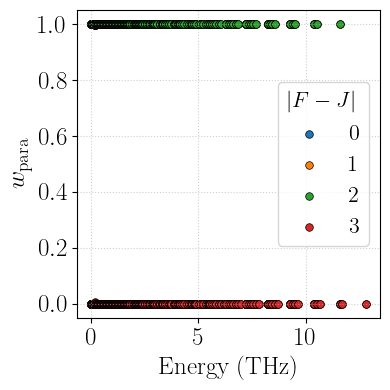

In [15]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[abs(f - j)].append((e, p_c))
    except KeyError:
        e_j[abs(f - j)] = [(e, p_c)]

fig = plt.figure(figsize=(4, 4), dpi=100)

colors = {0.0: "tab:blue", 1.0: "tab:orange", 2.0: "tab:green", 3.0: "tab:red"}

for key in sorted(list(e_j.keys())):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e/1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker="o",
        label=f"{int(key)}",
        s=30,
        facecolors=colors[key],
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(fontsize=16, title_fontsize=16, loc="center right", title="$|F-J|$")
plt.tight_layout()
plt.savefig(f"ch2cl2_35_35_op_diagram.pdf", format="pdf", bbox_inches="tight")

Compute expectation values of nuclear spin operators for selected states.

In [16]:
# Returns matrix elements of a selected Cartesian component of nuclear spin operators
def spin_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat1 = spin_tens1.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat1 = spin_tens1.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        mmat2 = spin_tens2.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat2 = spin_tens2.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat1 * mmat1, kmat2 * mmat2
    except KeyError:
        return 0, 0


# Returns matrix elements of a selected Cartesian component of electric dipole moment
def dip_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat = hyper_dip_lab.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat = hyper_dip_lab.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat * mmat
    except KeyError:
        return 0

In [17]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k==10 and j in (10,):  # select k and J

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)
        eTHz = round(e / 1e6, 6)
        eMHz = round(e, 4)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 10  10    1  3.0  7.0     59   3227681.0606     3.0     0.0     1.0     -1.312     -1.312
 10  10    0  3.0  7.0     61   3227681.0606     3.0     0.0     1.0     -1.312     -1.312
 10  10    1  1.0 10.0     74   3227683.6687     0.0     0.0     1.0      0.069      0.069
 10  10    0  1.0 10.0     72   3227683.6687     0.0     0.0     1.0      0.069      0.069
 10  10    1  0.0 10.0     74   3227683.6703     0.0     1.0     0.0      0.068      0.068
 10  10    0  0.0 10.0     76   3227683.6703     0.0     1.0     0.0      0.068      0.068
 10  10    1  3.0 13.0     74   3227685.9317     3.0     0.0     1.0      1.500      1.500
 10  10    0  3.0 13.0     76   3227685.9317     3.0     0.0     1.0      1.500      1.500
 10  10    0  3.0  8.0     64   3227695.2929     2.0     0.0     1.0     -0.722     -0.722
 10  10    1  3.0  8.0     66   3227695.2929     2.0     0.0     1.0     -0.722     -0.722

Plot nuclear spin densities for selected states.
Since these calculations are time-consuming, you may skip this cell if density plots are not required.

In [17]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k == 10 and j in (10,):  # select k and J
        eTHz = round(e / 1e6, 6)

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

        # plot_mc_dens(
        #     hyper_states,
        #     states,
        #     f,
        #     "A",
        #     m,
        #     ind,
        #     atom_xyz[3:],  # Cl1 and Cl2
        #     atom_labels=atom_labels[3:],  # Cl1 and Cl2
        #     npoints=200000,
        #     filename=f"dens_plots/ch2cl2_35_37_dens_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
        #     coef_thresh=1e-4,
        # )

        plot_mc_spin_dens(
            hyper_states,
            states,
            f,
            sym,
            m,
            ind,
            atom_xyz[3:],  # Cl1 and Cl2
            atom_labels=atom_labels[3:],  # Cl1 and Cl2
            cart_comp=cart_comp,
            npoints=200000,
            filename=f"dens_plots/ch2cl2_35_35_spindens_{cart_comp}_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
            coef_thresh=1e-4,
        )

  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 10  10    0  3.0  7.0     61   3227700.6313     3.0     0.0     1.0     -1.312     -1.312
 10  10    0  3.0  8.0     64   3227700.6313     2.0     0.0     1.0     -0.722     -0.722
 10  10    0  3.0  9.0     72   3227700.6313     1.0     0.0     1.0     -0.309     -0.309
 10  10    0  1.0  9.0     73   3227700.6313     1.0     0.0     1.0     -0.341     -0.341
 10  10    0  1.0 10.0     72   3227700.6313     0.0     0.0     1.0      0.069      0.069
 10  10    0  3.0 10.0     73   3227700.6313     0.0     0.0     1.0      0.249      0.249
 10  10    0  1.0 11.0     76   3227700.6313     1.0     0.0     1.0      0.567      0.567
 10  10    0  3.0 11.0     77   3227700.6313     1.0     0.0     1.0      0.641      0.641
 10  10    0  3.0 12.0     74   3227700.6313     2.0     0.0     1.0      1.115      1.115
 10  10    0  3.0 13.0     76   3227700.6313     3.0     0.0     1.0      1.500      1.500

### Compute spectrum

Define function `dipole_linestr` for computing transition linestrengths
$$
S(F',i\leftarrow F,j) = g_\text{ns}(\text{H})\sum_{m_F',m_F}\sum_{A=X,Y,Z}\left|\langle F',m_F',i|\mu_A|F,m_F,j\rangle\right|^2,
$$
where $i,j$ are indices of hyperfine states with total spin-rotational angular momentum $F'$ and $F$, respectively

In [18]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[float, float], dict[tuple[str, str], csr_array]]:
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            # selection rules from H-atom spin statistics
            if set(sym_pair) in (set(("A1", "A2")), set(("B1", "B2")), set(("A", "A"))):
                # added ("A", "A") pair to work when symmetries are switched off
                gns = gns_h[sym_pair[0]]
                ls_sym[sym_pair] = gns * m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls

Estimate partition function.

In [19]:
temp = 10.0  # Kelvin

if hyper_states.enr_units == "invcm":
    boltz_beta = constants.h * constants.c / (constants.k * temp) * 100
elif hyper_states.enr_units == "mhz":
    boltz_beta = constants.h / (constants.k * temp) * 1e6
else:
    raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")


enr, m_degen = np.array(
    [
        (e, (2 * f + 1) * gns_h[sym])
        for f in hyper_states.f_list
        for sym in hyper_states.f_sym_list[f]
        for e in hyper_states.enr[f][sym]
    ]
).T
zpe = np.min(enr)

part_func = np.sum(m_degen * np.exp(-(enr - zpe) * boltz_beta))
print(f"partition function for (T = {temp} K):", part_func)

partition function for (T = 10.0 K): 9398.669992140403


Define function `stick_spectrum` for computing absorption intensities for selected frequency range.

In [20]:
# precompute linestrenghts

ls = dipole_linestr(hyper_dip_lab)

In [21]:
def stick_spectrum(nu1, nu2):

    if hyper_states.enr_units == "invcm":
        fac_cm_molecule = 8.0e-45 * np.pi**3 / (3.0 * constants.h * constants.c)
    elif hyper_states.enr_units == "mhz":
        fac_cm_molecule = 8.0e-41 * np.pi**3 / (3.0 * constants.h * constants.c**2)
    else:
        raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

    freq = []
    abscoef = []
    spin_diff = []
    quanta = []
    w_para = []

    for (f1, f2), ls_j in ls.items():
        for (sym1, sym2), ls_sym in ls_j.items():

            enr1 = hyper_states.enr[f1][sym1]
            enr2 = hyper_states.enr[f2][sym2]
            spin1 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f1][sym1]]
            )
            spin2 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f2][sym2]]
            )
            qua1 = hyper_states.quanta_dict_k[f1][sym1]
            qua2 = hyper_states.quanta_dict_k[f2][sym2]
            w_para1 = [
                sum(c for (q, c) in qua if int(q) in (0, 2))
                for qua in hyper_states.quanta_dict_op[f1][sym1]
            ]
            w_para2 = [
                sum(c for (q, c) in qua if int(q) in (0, 2))
                for qua in hyper_states.quanta_dict_op[f2][sym2]
            ]

            # absorption coefficients

            spin12 = np.abs(spin1[:, None] - spin2[None, :])
            qua12 = np.array([[(q1, q2) for q2 in qua2] for q1 in qua1], dtype=object)
            w_para12 = np.array([[(w1, w2) for w2 in w_para2] for w1 in w_para1], dtype=object)

            nu = np.abs(enr1[:, None] - enr2[None, :])
            cond = enr1[:, None] < enr2[None, :]
            elow = np.where(cond, enr1[:, None], enr2[None, :])
            boltz_fac = np.exp(-(elow - zpe) * boltz_beta) / part_func
            intens = (
                ls_sym
                * boltz_fac
                * nu
                * (1 - np.exp(-abs(nu) * boltz_beta))
                * fac_cm_molecule
            )

            if f1 == f2:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=1)
            else:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=0)

            nu = nu[ind]
            intens = intens.toarray()[ind]
            spin12 = spin12[ind]
            qua12 = qua12[ind]
            w_para12 = w_para12[ind]

            ind = np.where((nu >= nu1) & (nu <= nu2))
            abscoef.append(intens[ind])
            freq.append(nu[ind])
            spin_diff.append(spin12[ind])
            quanta.append(qua12[ind])
            w_para.append(w_para12[ind])

    freq = np.concatenate(freq)
    abscoef = np.concatenate(abscoef)
    spin_diff = np.concatenate(spin_diff)
    quanta = np.concatenate(quanta)
    w_para = np.concatenate(w_para)
    return freq, abscoef, spin_diff, quanta, w_para

Plot stick spectrum for selected frequency range.

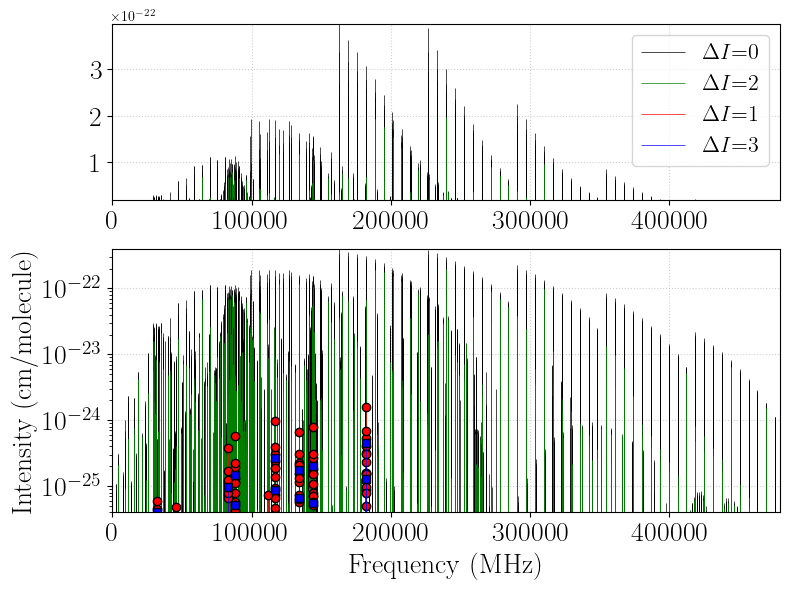

In [22]:
# frequency range (cm^-1)
nu1 = 0
nu2 = 16
if hyper_states.enr_units == "mhz":
    nu2 *= constants.c * 1e-4

freq, abscoef, spin_diff, quanta, w_para = stick_spectrum(nu1, nu2)

amax = np.max(abscoef)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 6), dpi=100, gridspec_kw={"height_ratios": [1, 1.5]}
)


color = ("black", "red", "green", "blue")
linewidth = (0.5, 0.5, 0.5, 0.5)
marker = ("", "o", "", "s")

for iax, ax in enumerate((ax1, ax2)):
    for diff in (0, 2, 1, 3):
        ind = np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0]

        if len(ind) == 0:
            continue

        ax.vlines(
            freq[ind],
            ymin=0,
            ymax=abscoef[ind],
            color=color[diff],
            linewidth=linewidth[diff],  # if iax == 0 else 1,
            label=f"$\\Delta I$={diff}",
        )

        if marker[diff]:
            ax.plot(
                freq[ind],
                abscoef[ind],
                linestyle="None",
                color=color[diff],
                mec="black",
                marker=marker[diff],  # if iax == 0 else "",
                markersize=6,
            )

for ax in (ax1, ax2):
    ax.set_xlim([nu1, nu2])
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=20)

ax2.set_yscale("log")
ax1.set_ylim([np.max(abscoef) * 5e-2, np.max(abscoef)])
ax2.set_ylim([np.max(abscoef) * 1e-4, np.max(abscoef)])
ax2.set_xlabel("Frequency (cm$^{-1}$)", fontsize=20)
if hyper_states.enr_units == "mhz":
    ax2.set_xlabel("Frequency (MHz)", fontsize=20)
ax2.set_ylabel("Intensity (cm/molecule)", fontsize=20)
ax1.legend(fontsize=16, loc="upper right")
plt.tight_layout()

plt.savefig(f"ch2cl2_35_35_op_spectrum_log.pdf", format="pdf", bbox_inches="tight")

Generate plot of the spectrum used in the manuscript.

max acoef: 3.981163833510549e-22


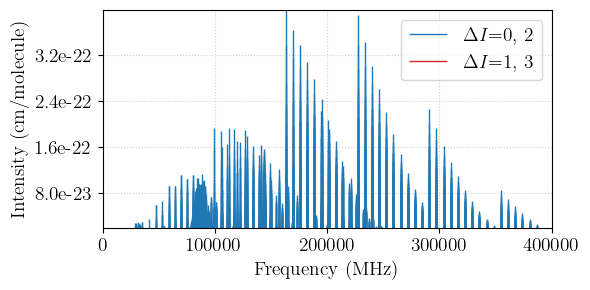

In [23]:
# frequency range (MHz)
nu1 = 0
nu2 = 400000
freq, abscoef, spin_diff, quanta, w_para = stick_spectrum(nu1, nu2)
w_para1, w_para2 = w_para.T

amax = np.max(abscoef)
print("max acoef:", amax)

fig = plt.figure(figsize=(6, 3), dpi=100)

diff_list = (0, 1, 2, 3)
color = ("tab:blue", "tab:red", "tab:blue", "tab:red")
linewidth = (1, 1, 1, 1)
marker = ("", "o", "", "o")

ind_list = [
    np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0] for diff in diff_list
]

for i, ind in enumerate(ind_list):
    if len(ind) == 0:
        continue
    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[i],
        linewidth=linewidth[i],
        label=(
            f"$\\Delta I$={diff_list[i]}, {diff_list[i]+2}"
            if diff_list[i] in (0, 1)
            else ""
        ),
    )

ind_mixed = np.where(
    ((w_para1 > 0.4) & (w_para1 < 0.6))
    | ((w_para2 > 0.4) & (w_para2 < 0.6)) & (abscoef >= amax * 1e-4)[0]
)
plt.vlines(
    freq[ind_mixed], ymin=0, ymax=abscoef[ind_mixed], color="tab:red", linewidth=1
)

for i, ind in enumerate(ind_list):
    if len(ind) == 0:
        continue
    if marker[diff_list[i]]:
        plt.plot(
            freq[ind],
            abscoef[ind],
            linestyle="None",
            color=color[i],
            mec="black",
            marker=marker[i],
            markersize=5,
        )


plt.xlim([nu1, nu2])
plt.ylim([amax * 5e-2, amax])
plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=14)

plt.xlabel("Frequency (cm$^{-1}$)", fontsize=14)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel("Intensity (cm/molecule)", fontsize=14)
plt.legend(fontsize=14, loc="upper right")

formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()

plt.savefig(f"ch2cl2_35_35_op_spectrum.pdf", format="pdf", bbox_inches="tight")